In [14]:
from __future__ import print_function, absolute_import, division, unicode_literals, with_statement
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.model_selection import ParameterGrid
import numpy as np
from confidentlearning.classification import RankPruning
from confidentlearning.noise_generation import generate_noisy_labels
from confidentlearning.util import value_counts
from confidentlearning.latent_algebra import compute_inv_noise_matrix

## **rankpruning** is the first practical *(works for any classifier, runs fast, robust to poor probability estimation)* algorithm for multiclass learning with noisy labels. Its comprised of components from the theory and algorithsm of **confident learning**. It's a Python class that wraps around any classifier as long as .fit(X, y, sample_weight), .predict(X), .predict_proba(X) are defined. Inspect the **confidentlearning** package for documentation.

## Here we show the performance of multiclass rankpruning wrapped around a sklearn LogisiticRegression classifier versus LogisticRegression without any help from confident learning on the Iris dataset.

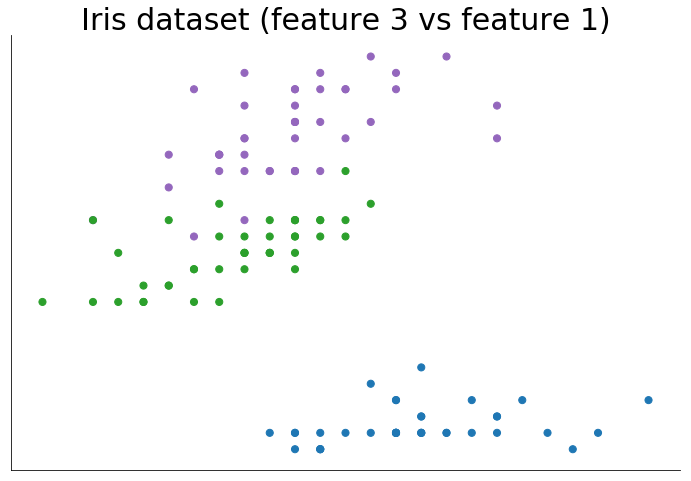

In [16]:
# Seed for reproducibility
seed = 2
rp = RankPruning(clf = logreg(), seed = seed)
np.random.seed(seed = seed)

# Get iris dataset
iris = datasets.load_iris()
X = iris.data  # we only take the first two features.
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


try:
    %matplotlib inline
    from matplotlib import pyplot as plt
    _ = plt.figure(figsize=(12,8))
    color_list = plt.cm.tab10(np.linspace(0, 1, 6))
    _ = plt.scatter(X_train[:,1], X_train[:,3], color = [color_list[z] for z in y_train], s = 50)  
    ax = plt.gca()
#     plt.axis('off')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    _ = ax.get_xaxis().set_ticks([])
    _ = ax.get_yaxis().set_ticks([])
    _ = plt.title("Iris dataset (feature 3 vs feature 1)", fontsize=30)
except Exception as e:
    print(e)
    print("Plotting is only supported in an iPython interface.")

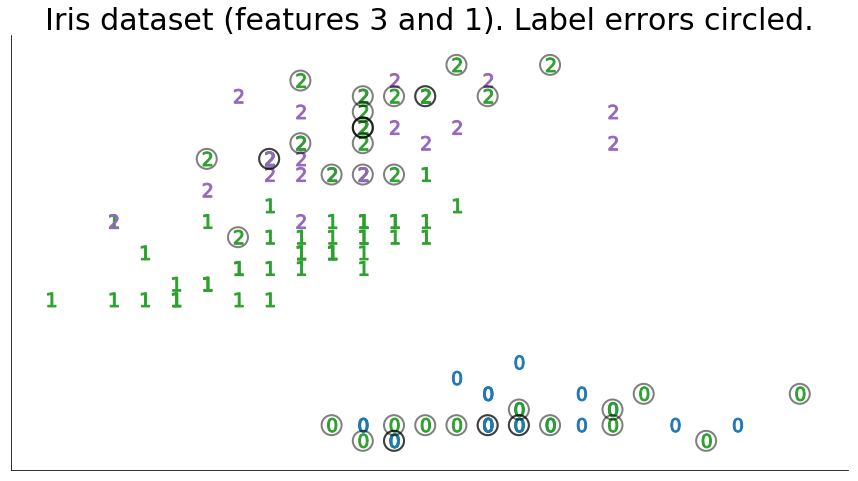

In [17]:
# Generate lots of noise.
noise_matrix = np.array([
    [0.5, 0.0, 0.0],
    [0.5, 1.0, 0.5],
    [0.0, 0.0, 0.5],
])

py = value_counts(y_train)
# Create noisy labels
s = generate_noisy_labels(y_train, noise_matrix)

try:
    %matplotlib inline
    from matplotlib import pyplot as plt
    _ = plt.figure(figsize=(15,8))
    color_list = plt.cm.tab10(np.linspace(0, 1, 6))
    for k in range(len(np.unique(y_train))):
        X_k = X_train[y_train == k] # data for class k
        _ = plt.scatter(X_k[:,1], X_k[:,3], color=[color_list[noisy_label] for noisy_label in s[y_train==k]], s=200, marker=r"${a}$".format(a=str(k)), linewidth=1)
#     plt.scatter(X_train[:,1], X_train[:,3], color = [color_list[z] for z in s], s = 50, marker=[r"${a}$".format(a=str(w)) for w in y_train]) 
    _ = plt.scatter(
        X_train[s != y_train][:,1], 
        X_train[s != y_train][:,3], 
        color = [color_list[z] for z in s], 
        s = 400, 
        facecolors='none', 
        edgecolors='black', 
        linewidth=2, 
        alpha = 0.5,
    ) 
    ax = plt.gca()
#     plt.axis('off')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    _ = ax.get_xaxis().set_ticks([])
    _ = ax.get_yaxis().set_ticks([])
    _ = plt.title("Iris dataset (features 3 and 1). Label errors circled.", fontsize=30)
except Exception as e:
    print(e)
    print("Plotting is only supported in an iPython interface.")

In [19]:


print('WITHOUT confident learning,', end=" ")
clf = logreg()
_ = clf.fit(X_train, s)
pred = clf.predict(X_test)
print("Iris dataset test accuracy:", round(accuracy_score(pred, y_test), 2))

print("\nNow we show the improvement using confident learning to characterize the noise")
print("and learn on the data that is (with high confidence) labeled correctly.")
print()
print('WITH confident learning (noise matrix given),', end=" ")
_ = rp.fit(X_train, s, noise_matrix = noise_matrix)
pred = rp.predict(X_test)
print("Iris dataset test accuracy:", round(accuracy_score(pred, y_test),2))

print('WITH confident learning (noise / inverse noise matrix given),', end=" ")
_ = rp.fit(X_train, s, noise_matrix = noise_matrix, inverse_noise_matrix=compute_inv_noise_matrix(py, noise_matrix))
pred = rp.predict(X_test)
print("Iris dataset test accuracy:", round(accuracy_score(pred, y_test),2))

print('WITH confident learning (using latent noise matrix estimation),', end=" ")
rp = RankPruning(clf = logreg(), seed = seed, prune_count_method='inverse_nm_dot_s')
_ = rp.fit(X_train, s)
pred = rp.predict(X_test)
print("Iris dataset test accuracy:", round(accuracy_score(pred, y_test),2))

print('WITH confident learning (using calibrated confident joint),', end=" ")
rp = RankPruning(clf = logreg(), seed = seed, prune_count_method='calibrate_confident_joint')
_ = rp.fit(X_train, s)
pred = rp.predict(X_test)
print("Iris dataset test accuracy:", round(accuracy_score(pred, y_test),2))

WITHOUT confident learning, Iris dataset test accuracy: 0.27

Now we show the improvement using confident learning to characterize the noise
and learn on the data that is (with high confidence) labeled correctly.

WITH confident learning (noise matrix given), Iris dataset test accuracy: 0.9
WITH confident learning (noise / inverse noise matrix given), Iris dataset test accuracy: 0.9
WITH confident learning (using latent noise matrix estimation), Iris dataset test accuracy: 0.9
WITH confident learning (using calibrated confident joint), Iris dataset test accuracy: 0.9


## The **rankpruning** algorithm's fit function has a few hyper-parameters. Although the default settings tend to work well, here we show the performance of confident learning across varying parameter settings. To learn more about the hyper-parameter settings, inspect ```confidentlearning/pruning.py```.

In [30]:
param_grid = {
    "prune_count_method": ["calibrate_confident_joint", "inverse_nm_dot_s"],
    "prune_method": ["prune_by_noise_rate", "prune_by_class", "both"],
    "converge_latent_estimates": [True, False],
}

# Fit RankPruning across all parameter settings.
params = ParameterGrid(param_grid)
scores = []
for param in params:
    rp = RankPruning(clf = logreg(), **param)
    _ = rp.fit(X_train, s) # s is the noisy y_train labels
    scores.append(accuracy_score(rp.predict(X_test), y_test))

# Print results sorted from best to least
for i in np.argsort(scores)[::-1]:
    print("Param settings:", params[i])
    print(
        "Iris dataset test accuracy (using confident learning):\t", 
        round(scores[i], 2),
        "\n"
    )

Param settings: {u'prune_method': u'prune_by_class', u'converge_latent_estimates': True, u'prune_count_method': u'inverse_nm_dot_s'}
Iris dataset test accuracy (using confident learning):	 1.0 

Param settings: {u'prune_method': u'prune_by_noise_rate', u'converge_latent_estimates': True, u'prune_count_method': u'inverse_nm_dot_s'}
Iris dataset test accuracy (using confident learning):	 1.0 

Param settings: {u'prune_method': u'prune_by_noise_rate', u'converge_latent_estimates': False, u'prune_count_method': u'inverse_nm_dot_s'}
Iris dataset test accuracy (using confident learning):	 0.93 

Param settings: {u'prune_method': u'prune_by_noise_rate', u'converge_latent_estimates': False, u'prune_count_method': u'calibrate_confident_joint'}
Iris dataset test accuracy (using confident learning):	 0.93 

Param settings: {u'prune_method': u'both', u'converge_latent_estimates': True, u'prune_count_method': u'inverse_nm_dot_s'}
Iris dataset test accuracy (using confident learning):	 0.93 

Param 